# CA3 Ensemble Formation 

In [1]:
 # -*- coding: utf-8 -*-
%matplotlib inline

from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

%run models.py

In [2]:
defaultclock.dt = 0.2*ms

In [3]:
def remove_upper_right_ticks(ax):
    '''Remove and lines from upper and right edges of figure'''
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [4]:
start_scope()

N = 1
Nin = 100

'''Simulation parameters'''
learning_rate = 0.02
w_init = 0.1
we_max = 1.0

'''Input'''
input_train = NeuronGroup(Nin,'rates : Hz',threshold='rand()<rates*dt')
input_train.rates = 10*Hz

'''Cells'''
enrns = ca3_neurongroup(N)
enrns.v = enrns.vr

'''Synapses'''
syns = ePlas_synapses(input_train,enrns)
syns.connect(True)
syns.post_rate = 10*Hz
syns.B = 5.0/(1.0*second*syns.post_rate)
syns.w = w_init
syns.wmax = we_max

'''Monitors'''
Mw = StateMonitor(syns,'w',True,dt=100*ms)
Mv = StateMonitor(enrns,'v',0)

'''Network'''
net = Network(collect())
mons = [Mw,Mv]
net.add(mons)
net.store('initialised')

'''Burn-in period with no plasticity'''
net.run(10*second,report='text',report_period=60*second)

'''Turn on plasticity and run'''
syns.A = learning_rate
net.run(190*second,report='text',report_period=60*second)

Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 20s
Starting simulation at t=10. s for a duration of 190. s
104.56631 s (55%) simulated in 1m 0s, estimated 49s remaining.
190. s (100%) simulated in 1m 43s


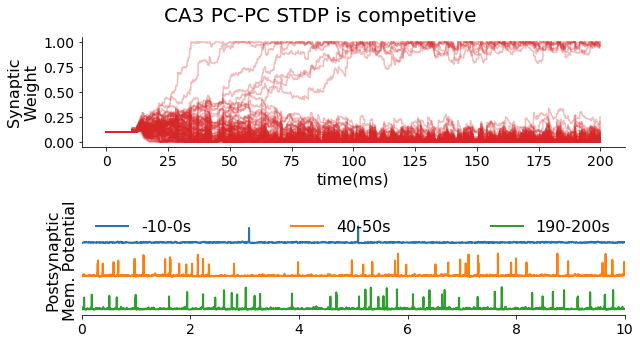

In [5]:
fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,4.5))

plt.sca(axs[0])
plt.plot(Mw.t,Mw.w.T,'C3',alpha=0.3);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time(ms)',fontsize=16)
plt.ylabel('Synaptic\nWeight',fontsize=16)

remove_upper_right_ticks(plt.gca())


plt.sca(axs[1])
win = 10
dt = 0.0002
time = np.arange(0,win,dt)
winsize = int(win/dt)
for a,ti in enumerate((np.array([10,50,197])/dt).astype('int')):
    plt.plot(time,Mv.v[0][ti-winsize:ti]/volt-a*0.15,lw=2)
plt.xlim(0,win)
plt.legend(('-10-0s','40-50s','190-200s'),mode='expand',ncol=3,fontsize=16,frameon=False)
plt.ylim(-0.4,0.1)
plt.xticks(fontsize=14)
plt.ylabel('Postsynaptic\nMem. Potential',fontsize=16)
plt.yticks([],'')

remove_upper_right_ticks(plt.gca())
axs[1].spines['left'].set_visible(False)
axs[1].yaxis.set_ticks_position('none')

fig.subplots_adjust(hspace=0.3)
fig.suptitle('CA3 PC-PC STDP is competitive',fontsize=20,y=1.05)
fig.tight_layout()

fig.savefig('./reworked_figs/eestdp.svg')

In [102]:
def single_ensemble_training(Ne,pattern,T,Ni=None,ffi=False):
    
    codegen.targets = 'cython'
    
    start_scope()
    
    '''Simulation parameters'''
    learning_rate = 0.02
    w_init = 0.1
    we_max = 1.0
    
    '''Pyramidal cells'''
    enrns = ca3_neurongroup(Ne)
    enrns.v = enrns.vr
    
    '''E-E cell synapses with STDP'''
    eesyns = ePlas_synapses(enrns,enrns)
    eesyns.connect('i!=j')
    eesyns.post_rate = 10*Hz
    eesyns.w = 0.0
    eesyns.B = 1.0/(1.*second*eesyns.post_rate)
    eesyns.wmax = we_max
    
    if Ni:
        wi_max = 2.0
        
        'Interneurons'
        inrns = fsbc_neurongroup(Ni)
        inrns.v = inrns.vr
        
        '''E-I cell synapses'''
        eisyns = eStat_synapses(enrns,inrns)
        eisyns.connect(True)
        eisyns.w = 0.3
        
        '''I-E cell synapses with STDP'''
        iesyns = iPlas_synapses(inrns,enrns)
        iesyns.connect(True)
        iesyns.B = 0.1
        iesyns.w = 0.3
        iesyns.wmax = wi_max
        
        '''I-I synapses'''
        iisyns = iStat_synapses(inrns,inrns)
        iisyns.connect('i!=j')
        iisyns.w = 0.3
    
    ''' Bursty or Irregular input to CA3 pyramidal cells'''
    
    if pattern == 'mossy':
        
        source_train = NeuronGroup(1,'rate = (0.2 + ((((t/second)-i)%20)<0.2)*50)*Hz : Hz',threshold='rand()<rate*dt')
        source_esyns = eMF_synapses(source_train,enrns)
        source_esyns.connect(True)
        source_esyns.w = 3.0
        source_esyns.p = 0.3
        source_esyns.p0 = 0.3
        
        if ffi:
            source_isyns = iMF_synapses(source_train,enrns)
            source_isyns.connect(True)
            source_isyns.w = 10.0
            source_isyns.p = 0.05
            source_isyns.p0 = 0.05
            source_isyns.y = 0.08
            source_isyns.y0 = 0.08
            source_isyns.q = 1.0
            
    if pattern == 'irregular':
        
        Nin = 120
        source_train = NeuronGroup(Nin,'rates : Hz', threshold='rand()<rates*dt')
        
        source_esyns = Synapses(source_train,enrns,
                                 model='''dg/dt = -g/(10*ms) : siemens (clock-driven)
                                         geff_tot_post=g: siemens (summed)
                                         w : 1
                                         p : 1''',
                                 on_pre='''g+=w*nsiemens*(rand()<p)''',
                                 method='linear')
        
        source_esyns.connect(True)
        source_train.rates = 10*Hz
        source_esyns.p = 0.9
        source_esyns.w = 0.1
        if ffi:
            source_isyns = Synapses(source_train,enrns,
                                   model='''
                                   dg/dt = -g/(20*ms) : siemens (clock-driven)
                                   giff_tot_post=g: siemens (summed)
                                   w : 1
                                   p : 1
                                   ''',
                                   on_pre='''g+=w*nsiemens*(rand()<p)''',
                                   method='linear',
                                   delay=5*ms)
            source_isyns.connect(True)
            source_isyns.p = 0.45
            source_isyns.w = 0.1
       
    '''Monitors'''
    Mwee = StateMonitor(eesyns,'w',True,dt=100*ms)
    Mwie = None
    if Ni:
        Mwie = StateMonitor(iesyns,'w',True,dt=100*ms)
    
    '''Network'''
    net = Network(collect())
    
    '''Burn-in period with no plasticity'''
    net.run(10*second,report='text',report_period=60*second)
    
    '''Run with plasticity'''
    eesyns.A = learning_rate
    if Ni:
        iesyns.A = learning_rate
    net.run((T-10)*second,report='text',report_period=60*second)
    
    return Mwee,Mwie

In [126]:
# We = []
# Wi = []
    
# Mwee,Mwie = single_ensemble_training(Ne=2,pattern='mossy',T=200)
# We.append(Mwee); Wi.append(Mwie)

# Mwee,Mwie = single_ensemble_training(Ne=10,pattern='mossy',T=200)
# We.append(Mwee); Wi.append(Mwie)

# Mwee,Mwie = single_ensemble_training(Ne=10,Ni=5,pattern='mossy',T=200)
# We.append(Mwee); Wi.append(Mwie)

# Mwee,Mwie = single_ensemble_training(Ne=10,Ni=5,ffi=True,pattern='mossy',T=200)
# We.append(Mwee); Wi.append(Mwie)

# Mwee,Mwie = single_ensemble_training(Ne=2,pattern='irregular',T=200)
# We.append(Mwee); Wi.append(Mwie)

# Mwee,Mwie = single_ensemble_training(Ne=10,pattern='irregular',T=200)
# We.append(Mwee); Wi.append(Mwie)

# Mwee,Mwie = single_ensemble_training(Ne=10,Ni=5,pattern='irregular',T=200)
# We.append(Mwee); Wi.append(Mwie)

Mwee,Mwie = single_ensemble_training(Ne=10,Ni=5,ffi=True,pattern='irregular',T=1000)
We.append(Mwee); Wi.append(Mwie)

Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 19s
Starting simulation at t=10. s for a duration of 0.99 ks
70.982802 s (7%) simulated in 1m 0s, estimated 12m 57s remaining.
138.186378 s (13%) simulated in 2m 0s, estimated 12m 20s remaining.
202.88565 s (20%) simulated in 3m 0s, estimated 11m 38s remaining.
273.786282 s (27%) simulated in 4m 0s, estimated 10m 28s remaining.
0.34503341 ks (34%) simulated in 5m 0s, estimated 9m 21s remaining.
0.41549369 ks (41%) simulated in 6m 0s, estimated 8m 18s remaining.
0.48285567 ks (48%) simulated in 7m 0s, estimated 7m 21s remaining.
0.55262434 ks (55%) simulated in 8m 0s, estimated 6m 20s remaining.
0.62270584 ks (62%) simulated in 9m 0s, estimated 5m 19s remaining.
0.69258757 ks (69%) simulated in 10m 0s, estimated 4m 18s remaining.
0.76350325 ks (77%) simulated in 11m 0s, estimated 3m 16s remaining.
0.83446526 ks (84%) simulated in 12m 0s, estimated 2m 14s remaining.
0.90606483 ks (91%) simulated in 13m 0s, es

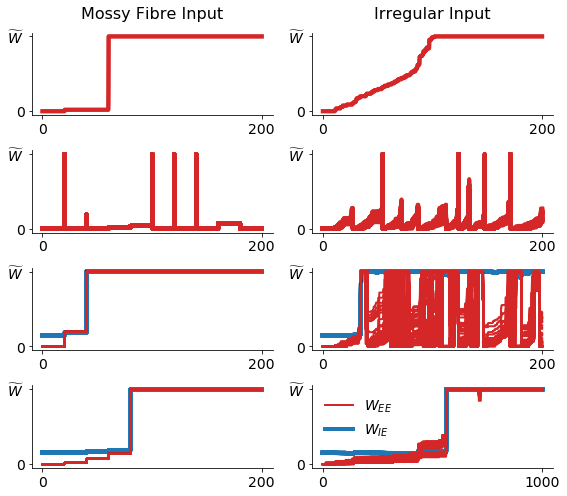

In [168]:
def plot_weight_evolution(ax,We,Wi):
    time = np.linspace(0,len(We.w.T)/10,len(We))
    plt.sca(ax)
    elw = 4
    l = []
    if Wi:
        l.append(plt.plot(time,Wi.w.T/2.0,lw=4,color='C0')[0])
        elw=2
    l.append(plt.plot(time,We.w.T/1.0,lw=elw,color='C3')[0])
    remove_upper_right_ticks(ax)
    return l[::-1]


fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(8,7))
axs_flat = np.ravel(axs.T)
for we,wi,ax in zip(We,Wi,axs_flat):
    l = plot_weight_evolution(ax,we,wi)
    plt.sca(ax)
    plt.xticks([0,ax.get_xticks()[-2]],fontsize=14)
    plt.yticks([0,1],['0',r'$\widetilde{W}$'],fontsize=14)
    
plt.sca(axs[0,0])
plt.title('Mossy Fibre Input',fontsize=16,y=1.1)
plt.sca(axs[0,1])
plt.title('Irregular Input',fontsize=16,y=1.1)
plt.sca(axs[3,1])
plt.legend(l,[r'$W_{EE}$',r'$W_{IE}$'],frameon=False,fontsize=14)

fig.tight_layout()

In [170]:
defaultclock.dt = 0.02*ms
codegen.targets = 'cython'

start_scope()
Nin = 50
Ne = 1

'''Pyramidal cells'''
enrns = ca3_neurongroup(Ne,ACh=0.0)
enrns.v = enrns.vr

'''Mossy fibre input'''

WTA_adapt = '''
dr/dt = r*(-rsum- 50*asum + I)/(10*ms) : 1
da/dt = -(a-r)/(5000*ms) : 1
I : 1
rsum : 1
asum : 1
'''
source_train = NeuronGroup(Nin,model=WTA_adapt,threshold='rand()<clip(r,0.01,inf)*dt/second')

summation = Synapses(source_train,source_train,model='''
rsum_post = r_pre : 1 (summed)
asum_post = a_pre : 1 (summed)
''')
summation.connect()

source_esyns = eMF_synapses(source_train,enrns)
source_esyns.connect(True)
source_esyns.w = 3.0
source_esyns.p = 0.3 
source_esyns.p0 = 0.3 

W = 100
s = 0.1
source_train.I = W*np.linspace(1-s,1+s,Nin)
source_train.r = 0.1

'''Monitors'''
Mv = StateMonitor(enrns,'v',True)
Mr = StateMonitor(source_train,'r',True)
S = SpikeMonitor(source_train)
Se = SpikeMonitor(enrns)

'''Network'''
net = Network(collect())
mons = [Mv,Mr]
net.add(mons)
net.store('initialised')

'''Retrieval with no plasticity'''
net.run(400*ms,report='text',report_period=60*second)

INFO       No numerical integration method specified for group 'neurongroup_16', using method 'linear' (took 0.33s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 0.4 s
0.4 s (100%) simulated in 8s


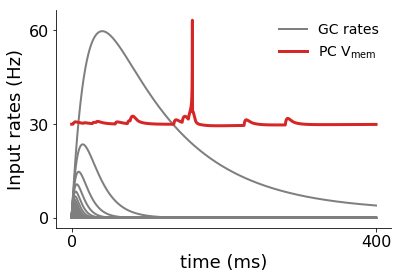

In [175]:
fig = plt.figure(figsize=(6,4))
l1 = plt.plot(Mr.t/ms,Mr.r.T,lw=2,color='C7')[0]
l2 = plt.plot(Mv.t/ms,(Mv.v[0]/mV - enrns.vr/mV)/3 + 30,color='C3',lw=3)[0]
plt.ylabel('Input rates (Hz)',fontsize=18)
plt.yticks([0,30,60],fontsize=16)
plt.xlabel('time (ms)',fontsize=18)
plt.xticks([0,400],fontsize=16)
ax = plt.gca()
remove_upper_right_ticks(ax)

plt.legend([l1,l2],['GC rates','PC V$_\mathrm{mem}$'],frameon=False,fontsize=14)

In [4]:
def ca3_ensemble_training(ach,freq,nol):
    start_scope()

    codegen.targets = 'cython'

    Nin = 8
    Nol = nol
    Ne = Nin*(Nin - Nol)
    Ni = Ne/4

    '''Simulation parameters'''
    learning_rate = 0.02
    w_init = 0.0
    we_max = 0.5
    wi_max = 1.0

    '''Acetylcholine on or off in experiment'''
    ach_ex = ach_syn = ach_ffi = ach

    '''Pyramidal cells'''
    enrns = ca3_neurongroup(Ne,ACh=[ach_ex,ach_syn])
    enrns.v = enrns.vr

    '''Interneurons'''
    inrns = fsbc_neurongroup(Ni,ACh=ach_ex)
    inrns.v= inrns.vr

    '''E-E cell synapses with STDP'''
    eesyns = ePlas_synapses(enrns,enrns)
    eesyns.connect('i!=j')
    eesyns.post_rate = 10*Hz
    eesyns.B = 1.0/(1.*second*eesyns.post_rate)
    eesyns.w = 0.0
    eesyns.wmax = we_max

    '''E-I cell synapses'''
    eisyns = eStat_synapses(enrns,inrns)
    eisyns.connect(True)
    eisyns.w = 0.3

    '''I-E cell synapses with STDP'''
    iesyns = iPlas_synapses(inrns,enrns)
    iesyns.connect(True)
    iesyns.B = 0.1
    iesyns.w = 0.3
    iesyns.wmax = wi_max

    '''I-I cell synapses'''
    iisyns = iStat_synapses(inrns,inrns)
    iisyns.connect('i!=j')
    iisyns.w = 0.3

    '''Bursty, facilitating inhomogeneous poisson input'''

    source_train = NeuronGroup(Nin,
                               model='''
                               rate = (0.2 + ((((t/second)-i)%20)<0.25)*burst_freq)*Hz : Hz
                               burst_freq : 1
                               ''',
                               threshold='rand()<rate*dt')
    source_train.burst_freq = freq
    
    source_esyns = eMF_synapses(source_train,enrns)
    source_isyns = iMF_synapses(source_train,enrns)


    '''Input for independent assembly '''
    Cpre = repeat(range(Nin),Ne/Nin)
    Cpost = range(Ne)

    '''Input for assembly overlaps'''
    for ii in xrange(Nol):
        Cpre=np.append(Cpre,np.arange(Nin))
        Cpost=np.append(Cpost,np.arange(Ne)[np.arange(Nin)*Ne/Nin -ii - 1])

    source_esyns.connect(i=Cpre,j=Cpost) # For studying multiple assemblies

    source_esyns.w = 3.0 
    source_esyns.p = 0.3
    source_esyns.p0 = 0.3 

    source_isyns.connect(True)

    source_isyns.w = 10.0/(1+5*ach_ffi) # For MF with facilitation
    source_isyns.p=0.05*(1+2*ach_ffi)
    source_isyns.p0=0.05*(1+2*ach_ffi)
    source_isyns.y = 0.08
    source_isyns.y0 = 0.08
    source_isyns.q = 1.0

    # Target Weight Matrix

    def targetWeightMatrix(Cpre,Cpost,Ne):
        w_target = np.zeros((Ne,Ne))
        for ix,wrow in enumerate(w_target):
            sources = Cpre[np.where(Cpost==ix)[0]]
            for src in sources:
                wrow[Cpost[Cpre==src]] = we_max

        w_target[range(Ne),range(Ne)] = np.nan
        w_target = np.ravel(w_target)
        w_target = w_target[~np.isnan(w_target)]
        return w_target
    
    eSpikeMonitor = SpikeMonitor(enrns)
    iSpikeMonitor = SpikeMonitor(inrns)
    
    '''Network'''
    net = Network(collect())
    net.store('initialised')

    '''Burn-in Period with no plasticity'''
    net.run(10*second,report='text',report_period=60*second)

    '''Run with plasticity'''
    eesyns.A =iesyns.A = learning_rate
    net.run(390*second,report='text',report_period=60*second)
    
    return eesyns.i,eesyns.j,eesyns.w,[eSpikeMonitor.i,iSpikeMonitor.i],[eSpikeMonitor.t,iSpikeMonitor.t]

In [11]:
i30,j30,w30,sn30,st30 = ca3_ensemble_training(nol=0,ach=0,freq=30)
i20,j20,w20,sn20,st20 = ca3_ensemble_training(nol=0,ach=0,freq=20)
i20a,j20a,w20a,sn20a,st20a = ca3_ensemble_training(nol=0,ach=1,freq=20)

Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 11s
Starting simulation at t=10. s for a duration of 0.39 ks
46.074795 s (11%) simulated in 1m 0s, estimated 7m 28s remaining.
87.749805 s (22%) simulated in 2m 0s, estimated 6m 53s remaining.
129.037935 s (33%) simulated in 3m 0s, estimated 6m 4s remaining.
169.819065 s (43%) simulated in 4m 0s, estimated 5m 11s remaining.
210.63198 s (54%) simulated in 5m 0s, estimated 4m 15s remaining.
250.576755 s (64%) simulated in 6m 0s, estimated 3m 20s remaining.
292.00977 s (74%) simulated in 7m 0s, estimated 2m 21s remaining.
0.33368341 ks (85%) simulated in 8m 0s, estimated 1m 21s remaining.
0.37491168 ks (96%) simulated in 9m 0s, estimated 22s remaining.
0.39 ks (100%) simulated in 9m 8s
Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 11s
Starting simulation at t=10. s for a duration of 0.39 ks
44.73768 s (11%) simulated in 1m 0s, estimated 7m 43s remaining.
89.63799 s (22%) simul

In [5]:
def binSpikeCounts(t,n,binsize=0.25):
    bins = np.arange(0,400,0.25)
    X = [(n[np.logical_and((t>b1),(t<=b2))]).tolist() for b1,b2 in zip(bins[:-1],bins[1:])]
    N = np.max(n)+1

    Counts = []
    for x in X:
        c = np.zeros(N)
        if any(x):
            unique,counts=np.unique(x,return_counts=True)
            c[unique]=counts
        Counts.append(c)
    Counts = np.array(Counts)
    tt,nn = np.nonzero(Counts)
    cc = Counts[(tt,nn)]
    tt=tt/4
    return tt,nn,cc

In [6]:
from matplotlib.colors import LinearSegmentedColormap

rgb = [(214/256.,39/256.,40/256.)]*256
alpha = np.linspace(0,1,256)
rgba = tuple([(214/256.,39/256.,40/256.,a) for a in alpha])
alphareds = LinearSegmentedColormap.from_list('alphareds',rgba)

def plot_wmatrix(i,j,w,N):
    matrix = np.zeros((N,N))
    matrix[i,j] = w
    im = plt.imshow(matrix,cmap=alphareds,interpolation='nearest',origin='lower')
    remove_upper_right_ticks(plt.gca())
    return im

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_YlOrRd = truncate_colormap(plt.cm.YlOrRd,minval=0.3)
new_BuPu = truncate_colormap(plt.cm.BuPu,minval=0.15)

def plotBurstRaster(t,n,Ne):
    te=t[0]/second
    ne=n[0]
    
    ti=t[1]/second
    ni=n[1]
    
    tte,nne,cce = binSpikeCounts(te,ne)
    tti,nni,cci = binSpikeCounts(ti,ni)
    
    sre = plt.scatter(tte,nne,s=10,c=cce,cmap=new_YlOrRd,vmin=1,vmax=10)
    sri = plt.scatter(tti,nni+Ne,s=10,c=cci,cmap=new_BuPu,vmin=1,vmax=6)
    
    remove_upper_right_ticks(plt.gca())
    return sre,sri

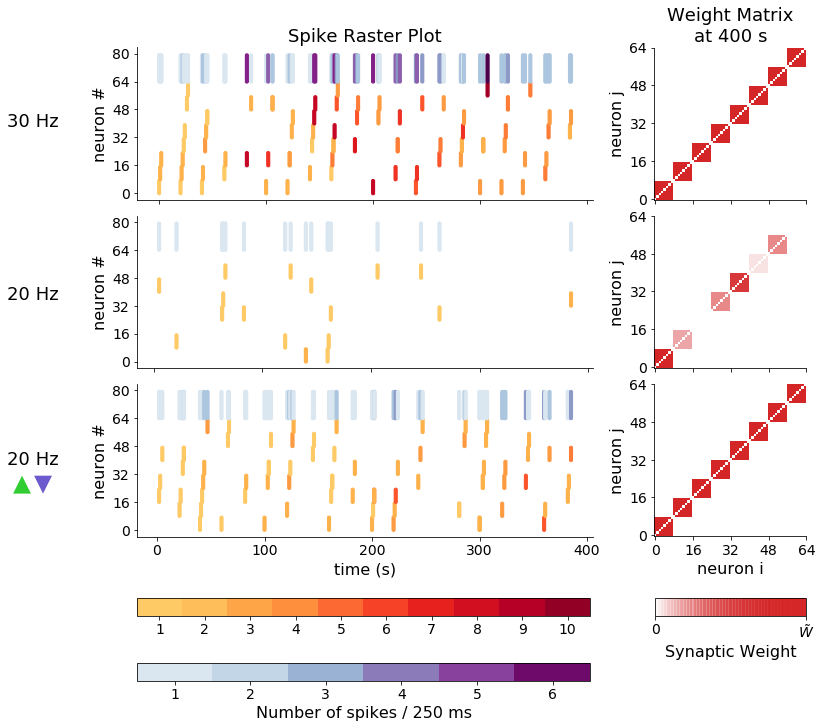

In [218]:
fig,axs = plt.subplots(figsize=(12,10),nrows=3,ncols=2,gridspec_kw={'width_ratios' : [3,1]})

plt.sca(axs[0,0])
sre,sri=plotBurstRaster(st30,sn30,Ne=64)
plt.xticks([0,100,200,300,400],[]*5)
plt.yticks([0,16,32,48,64,80],fontsize=14)
plt.title('Spike Raster Plot',fontsize=18)
plt.ylabel('neuron #',fontsize=16)
fig.text(x=-0.025,y=0.77,s='30 Hz',fontsize=18)

plt.sca(axs[0,1])
wm = plot_wmatrix(i30,j30,w30,N=64)
plt.xticks([0,16,32,48,64],[]*5)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.title('Weight Matrix\nat 400 s',fontsize=18)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[1,0])
plotBurstRaster(st20,sn20,Ne=64)
plt.xticks([0,100,200,300,400],[]*5)
plt.yticks([0,16,32,48,64,80],fontsize=14)
plt.ylabel('neuron #',fontsize=16)
fig.text(x=-0.025,y=0.535,s='20 Hz',fontsize=18)

plt.sca(axs[1,1])
plot_wmatrix(i20,j20,w20,N=64)
plt.xticks([0,16,32,48,64],[]*5)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[2,0])
plotBurstRaster(st20a,sn20a,Ne=64)
plt.xticks([0,100,200,300,400],fontsize=14)
plt.yticks([0,16,32,48,64,80],fontsize=14)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('neuron #',fontsize=16)
fig.text(x=-0.025,y=0.30,s='20 Hz',fontsize=18)
fig.text(x=-0.020,y=0.26,s=r'$\blacktriangle$',color='limegreen',fontsize=36,transform=axs[0,1].transAxes)
fig.text(x=0.005,y=0.26,s=r'$\blacktriangledown$',color='slateblue',fontsize=36,transform=axs[0,1].transAxes)


plt.sca(axs[2,1])
plot_wmatrix(i20a,j20a,w20a,N=64)
plt.xticks([0,16,32,48,64],fontsize=14)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.xlabel('neuron i',fontsize=16)
plt.ylabel('neuron j',fontsize=16)

fig.subplots_adjust(hspace=0.1,wspace=0.2,bottom=0.2)

cax_e = fig.add_axes([0.125,0.09,0.525,0.025])
plt.colorbar(sre,cax=cax_e,orientation='horizontal',boundaries=range(11),ticks=np.linspace(0.5,9.5,10))
cax_e.set_xticklabels(range(1,11),fontsize=14)

cax_i = fig.add_axes([0.125,0.00,0.525,0.025])
plt.colorbar(sri,cax=cax_i,orientation='horizontal',boundaries=range(7),ticks=np.linspace(0.5,5.5,6))
cax_i.set_xticklabels(range(1,7),fontsize=14)
plt.xlabel('Number of spikes / 250 ms',fontsize=16)

cax_w = fig.add_axes([0.725,0.09,0.175,0.025])
plt.colorbar(wm,cax=cax_w,orientation='horizontal',ticks=[0,0.5])
cax_w.set_xticklabels(['0',r'$\tilde{W}$'],fontsize=14)
plt.xlabel('Synaptic Weight',fontsize=16)

fig.savefig('./reworked_figs/ensemble_formation_ach_example.svg')

In [30]:
# i0,j0,w0,sn0,st0 = ca3_ensemble_training(nol=0,ach=0,freq=30)
i2,j2,w2,sn2,st2 = ca3_ensemble_training(nol=2,ach=0,freq=30)
# i4,j4,w4,sn4,st4 = ca3_ensemble_training(nol=4,ach=0,freq=30)

# i0a,j0a,w0a,sn0a,st0a = ca3_ensemble_training(nol=0,ach=1,freq=30)
# i2a,j2a,w2a,sn2a,st2a = ca3_ensemble_training(nol=2,ach=1,freq=30)
# i4a,j4a,w4a,sn4a,st4a = ca3_ensemble_training(nol=4,ach=1,freq=30)

WARNING    "a" is an internal variable of group "neurongroup_6", but also exists in the run namespace with the value 1.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "a" is an internal variable of group "neurongroup_7", but also exists in the run namespace with the value 1.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 10. s
10. s (100%) simulated in 12s
Starting simulation at t=10. s for a duration of 0.39 ks
43.64217 s (11%) simulated in 1m 0s, estimated 7m 56s remaining.
81.91404 s (21%) simulated in 2m 0s, estimated 7m 31s remaining.
113.95527 s (29%) simulated in 3m 0s, estimated 7m 16s remaining.
150.984405 s (38%) simulated in 4m 0s, estimated 6m 20s remaining.
188.35089 s (48%) simulated in 5m 0s, estimated 5m 21s remaining.
232.90644 s (59%) simulated in 6m 0s, estimated 4m 3s remaining.
271.979565 s (69%) simulated in 7m 0s, estimated 3m 2s remaining.
314.302755 s (80%) simulated in 8m 0s, estimated 1m 56s remaining.
0.35914359 ks (92%) simulated in 9m 0s, estimated 46s remaining.
0.39 ks (100%) simulated in 9m 29s


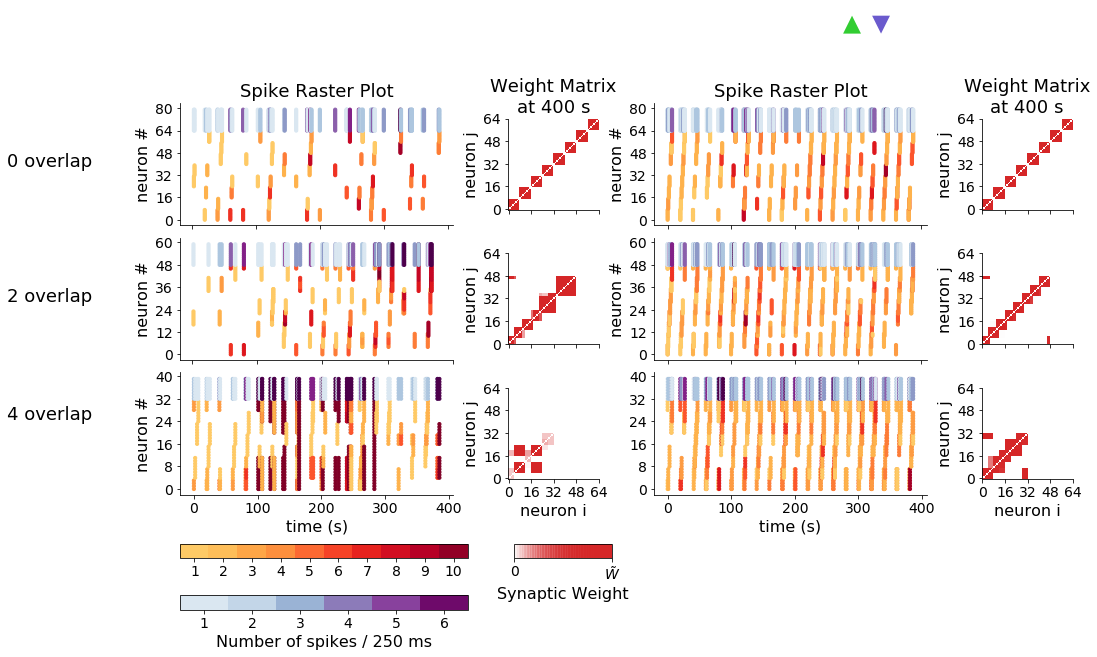

In [33]:
fig,axs = plt.subplots(figsize=(16,8),nrows=3,ncols=4,gridspec_kw={'width_ratios':[3,1,3,1]})

plt.sca(axs[0,0])
sre,sri=plotBurstRaster(st0,sn0,Ne=64)
plt.xticks([0,100,200,300,400],[]*5)
plt.yticks([0,16,32,48,64,80],fontsize=14)
plt.title('Spike Raster Plot',fontsize=18)
plt.ylabel('neuron #',fontsize=16)

plt.sca(axs[0,1])
wm = plot_wmatrix(i0,j0,w0,N=64)
plt.xticks([0,16,32,48,64],[]*5)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.title('Weight Matrix\nat 400 s',fontsize=18)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[0,2])
sre,sri=plotBurstRaster(st0a,sn0a,Ne=64)
plt.xticks([0,100,200,300,400],[]*5)
plt.yticks([0,16,32,48,64,80],fontsize=14)
plt.title('Spike Raster Plot',fontsize=18)
plt.ylabel('neuron #',fontsize=16)

plt.sca(axs[0,3])
wm = plot_wmatrix(i0a,j0a,w0a,N=64)
plt.xticks([0,16,32,48,64],[]*5)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.title('Weight Matrix\nat 400 s',fontsize=18)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[1,0])
sre,sri=plotBurstRaster(st2,sn2,Ne=48)
plt.xticks([0,100,200,300,400],[]*5)
plt.yticks([0,12,24,36,48,60],fontsize=14)
plt.ylabel('neuron #',fontsize=16)

plt.sca(axs[1,1])
wm = plot_wmatrix(i2,j2,w2,N=48)
plt.xticks([0,16,32,48,64],[]*5)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[1,2])
sre,sri=plotBurstRaster(st2a,sn2a,Ne=48)
plt.xticks([0,100,200,300,400],[]*5)
plt.yticks([0,12,24,36,48,60],fontsize=14)
plt.ylabel('neuron #',fontsize=16)

plt.sca(axs[1,3])
wm = plot_wmatrix(i2a,j2a,w2a,N=48)
plt.xticks([0,16,32,48,64],[]*5)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[2,0])
sre,sri=plotBurstRaster(st4,sn4,Ne=32)
plt.xticks([0,100,200,300,400],fontsize=14)
plt.yticks([0,8,16,24,32,40],fontsize=14)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('neuron #',fontsize=16)

plt.sca(axs[2,1])
wm = plot_wmatrix(i4,j4,w4,N=32)
plt.xticks([0,16,32,48,64],fontsize=14)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.xlabel('neuron i',fontsize=16)
plt.ylabel('neuron j',fontsize=16)

plt.sca(axs[2,2])
sre,sri=plotBurstRaster(st4a,sn4a,Ne=32)
plt.xticks([0,100,200,300,400],fontsize=14)
plt.yticks([0,8,16,24,32,40],fontsize=14)
plt.xlabel('time (s)',fontsize=16)

plt.sca(axs[2,3])
wm = plot_wmatrix(i4a,j4a,w4a,N=32)
plt.xticks([0,16,32,48,64],fontsize=14)
plt.yticks([0,16,32,48,64],fontsize=14)
plt.xlabel('neuron i',fontsize=16)
plt.ylabel('neuron j',fontsize=16)

fig.subplots_adjust(hspace=0.1,wspace=0.3,bottom=0.2)

cax_e = fig.add_axes([0.125,0.09,0.25,0.025])
plt.colorbar(sre,cax=cax_e,orientation='horizontal',boundaries=range(11),ticks=np.linspace(0.5,9.5,10))
cax_e.set_xticklabels(range(1,11),fontsize=14)

cax_i = fig.add_axes([0.125,0.00,0.25,0.025])
plt.colorbar(sri,cax=cax_i,orientation='horizontal',boundaries=range(7),ticks=np.linspace(0.5,5.5,6))
cax_i.set_xticklabels(range(1,7),fontsize=14)
plt.xlabel('Number of spikes / 250 ms',fontsize=16)

cax_w = fig.add_axes([0.415,0.09,0.085,0.025])
plt.colorbar(wm,cax=cax_w,orientation='horizontal',ticks=[0,0.5])
cax_w.set_xticklabels(['0',r'$\tilde{W}$'],fontsize=14)
plt.xlabel('Synaptic Weight',fontsize=16)

fig.text(x=0.700,y=1.0,s=r'$\blacktriangle$',color='limegreen',fontsize=36,transform=axs[0,1].transAxes)
fig.text(x=0.725,y=1.0,s=r'$\blacktriangledown$',color='slateblue',fontsize=36,transform=axs[0,1].transAxes)

fig.text(x=-0.025,y=0.770,s='0 overlap',fontsize=18)
fig.text(x=-0.025,y=0.535,s='2 overlap',fontsize=18)
fig.text(x=-0.025,y=0.330,s='4 overlap',fontsize=18)

fig.savefig('./reworked_figs/ensemble_formation_overlap_ach_example.svg')

#  MAPS (Preliminary)

## Fac

WARNING    /home/luke/anaconda2/envs/SpNN/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: Mean of empty slice
 [py.warnings]


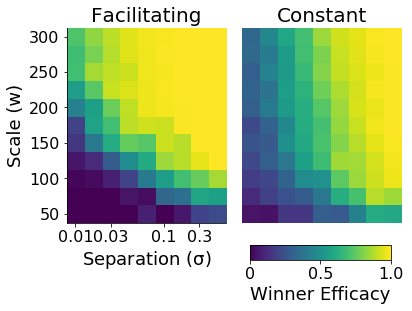

In [20]:
with open('./ca3_fac_wta_0.csv','r') as myfile:
    E0 = numpy.loadtxt(myfile,delimiter=',')
    
with open('./ca3_fac_wta_1.csv','r') as myfile:
    E1 = numpy.loadtxt(myfile,delimiter=',')
    
E0 = numpy.reshape(E0,(99,30))
ME0 = numpy.nanmean(numpy.reshape(E0,(99,30)),axis=1)
Z0 = numpy.sum(~numpy.isnan(E0),axis=1)/30.
ME0 = numpy.nan_to_num(ME0*Z0)

E1 = numpy.reshape(E1,(99,30))
ME1 = numpy.nanmean(numpy.reshape(E1,(99,30)),axis=1)
Z1 = numpy.sum(~numpy.isnan(E1),axis=1)/30.
ME1 = numpy.nan_to_num(ME1*Z1)

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(6,4))

plt.sca(ax2)
I = plt.imshow(numpy.reshape(ME0,(11,9)),vmin=0,vmax=1,origin='lower',cmap=plt.cm.viridis,interpolation='nearest')
ax2.axis('off')
plt.title('Constant',fontsize=20)

plt.sca(ax1)
plt.imshow(numpy.reshape(ME1,(11,9)),vmin=0,vmax=1,origin='lower',cmap=plt.cm.viridis,interpolation='nearest')
plt.title('Facilitating',fontsize=20)
plt.xticks([0,2,5,7],[0.01,0.03,0.1,0.3],fontsize=16)
plt.yticks(range(11)[::2],(numpy.linspace(50,300,11)[::2]).astype('int'),fontsize=16)
plt.ylabel('Scale (w)',fontsize=18)
plt.xlabel('Separation ($\mathrm{\sigma}$)',fontsize=18)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

fig.subplots_adjust(wspace=0.1)

cax = fig.add_axes([0.55, 0.035, 0.325, 0.05])
fig.colorbar(I,cax=cax,label='Winner Efficacy',orientation='horizontal',ticks=[0,0.5,1.0])
cax.set_xticklabels([0,0.5,1.0],fontsize=16)
cax.set_xlabel(cax.get_xlabel(),fontsize=18)

fig.savefig('./reworked_figs/mf-facilitation-separation-map.svg')

## Reqs

In [37]:
with open('./.gitignore/MF_err_ach.csv','rb') as myfile:
    E = numpy.loadtxt(myfile,delimiter=',')


E = E[numpy.argsort(E[:,0])]

ac = (E.T[1]).astype('int')
freq0 = E.T[0][ac==0]
E0 = E.T[2::20].T[ac==0]

freq1 = E.T[0][ac==1]
E1 = E.T[2::20].T[ac==1]

time = numpy.linspace(0,400,1000)
freq  = numpy.unique(freq0)

T,F = numpy.meshgrid(time,freq)

ME0 = numpy.squeeze([(E0[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(freq))])
ME1 = numpy.squeeze([(E1[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(freq))])

with open('./.gitignore/MF_err_achnoex.csv','rb') as myfile:
    E = numpy.loadtxt(myfile,delimiter=',')

E = E[numpy.argsort(E[:,0])]

acex = (E.T[1]).astype('int')
acsy = (E.T[2]).astype('int')
acfi = (E.T[3]).astype('int')

freq0 = E.T[0][acex==0]
Eex = E.T[4::20].T[acex==0]
Esy = E.T[4::20].T[acsy==0]
Efi = E.T[4::20].T[acfi==0]

time = numpy.linspace(0,400,1000)
freq  = numpy.unique(freq0)

T,F = numpy.meshgrid(time,freq)
MEex = numpy.squeeze([(Eex[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(freq))])
MEsy = numpy.squeeze([(Esy[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(freq))])
MEfi = numpy.squeeze([(Efi[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(freq))])

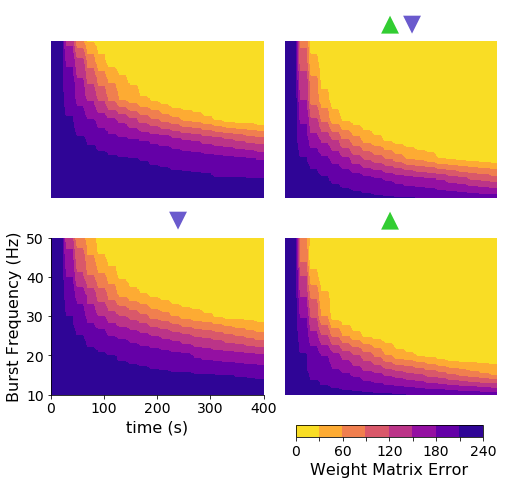

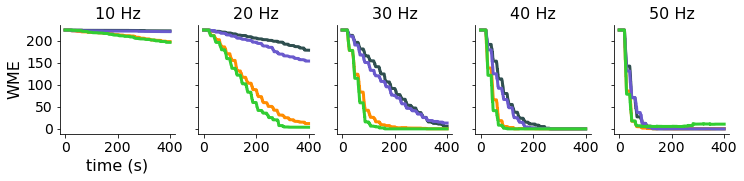

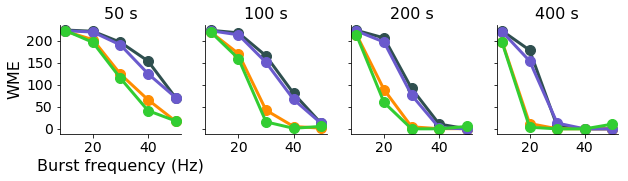

In [38]:
## Colormap

fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(8,6.5))

plt.sca(axs[0,0])
plt.contourf(T,F,ME0,N=12,aspect=500,cmap='plasma_r',interpolation='nearest')
axs[0,0].axis('off')

plt.sca(axs[0,1])
C1 = plt.contourf(T,F,ME1,N=12,aspect=500,cmap='plasma_r',interpolation='nearest')
axs[0,1].axis('off')
plt.text(x=0.45,y=1.05,s=r'$\blacktriangle$',color='limegreen',fontsize=36,transform=axs[0,1].transAxes)
plt.text(x=0.55,y=1.05,s=r'$\blacktriangledown$',color='slateblue',fontsize=36,transform=axs[0,1].transAxes)

plt.sca(axs[1,0])
C1 = plt.contourf(T,F,MEex,N=12,aspect=500,cmap='plasma_r',interpolation='nearest')
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('Burst Frequency (Hz)',fontsize=16)
plt.xticks([0,100,200,300,400],fontsize=14)
plt.yticks([10,20,30,40,50],fontsize=14)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
plt.text(x=0.55,y=1.05,s=r'$\blacktriangledown$',color='slateblue',fontsize=36,transform=axs[1,0].transAxes)

plt.sca(axs[1,1])
C1 = plt.contourf(T,F,MEsy,N=12,aspect=500,cmap='plasma_r',interpolation='nearest')
axs[1,1].axis('off')
plt.text(x=0.45,y=1.05,s=r'$\blacktriangle$',color='limegreen',fontsize=36,transform=axs[1,1].transAxes)

fig.subplots_adjust(wspace=0.1,hspace=0.25)

cax = fig.add_axes([0.55, 0.035, 0.325, 0.025])
fig.colorbar(C1,cax=cax,label='Weight Matrix Error',orientation='horizontal')
cax.set_xticklabels(['0','','60','','120','','180','','240'],fontsize=14)
cax.set_xlabel(cax.get_xlabel(),fontsize=16);

fig.savefig('./reworked_figs/ensemble_formation_ach_fullmap.svg')

#----------------------------------------------------------------------------------------------------------

fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(12,2),sharex=True,sharey=True)

colors = ['darkslategrey','darkorange','slateblue','limegreen']

for i in range(5):
    plt.sca(axs[i])
    for color,M in zip(colors,[ME0,ME1,MEex,MEsy]):
        plt.plot(time,M[i*2,:],color,lw=3)
        
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.title('%d'%((i+1)*10) + ' Hz',fontsize=16)
    
plt.sca(axs[0])
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('WME',fontsize=16)
plt.yticks(fontsize=14)

fig.savefig('./reworked_figs/ensemble_formation_ach_freqslice.svg')

#----------------------------------------------------------------------------------------------------------

fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,2),sharex=True,sharey=True)

colors = ['darkslategrey','darkorange','slateblue','limegreen']

freq = [10,20,30,40,50]

for i in range(4):
    plt.sca(axs[i])
    for color,M in zip(colors,[ME0,ME1,MEex,MEsy]):
        plt.plot(freq,M[::2,int(250*2**(i-1)-1)],'-o',color=color,lw=3,ms=10)
        
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.title('%d'%(100*2**(i-1)) + ' s',fontsize=16)

plt.sca(axs[0])
plt.xlabel('Burst frequency (Hz)',fontsize=16)
plt.ylabel('WME',fontsize=16)
plt.yticks(fontsize=14)

fig.savefig('./reworked_figs/ensemble_formation_ach_timeslice.svg')

##  Overlap

In [41]:
with open('./.gitignore/MF_err_ol_ach.csv','rb') as myfile:
    E = numpy.loadtxt(myfile,delimiter=',')

acex = (E.T[1]).astype('int')
acsy = (E.T[2]).astype('int')
acfi = (E.T[3]).astype('int')

overlap = range(5)

Einit = E[:60,4][:,numpy.newaxis]

E0= (E[:,4::20][(acex==0)*(acsy==0)*(acfi==0)])/Einit
E1= (E[:,4::20][(acex==1)*(acsy==1)*(acfi==1)])/Einit
Eex=(E[:,4::20][(acex==0)*(acsy==1)*(acfi==1)])/Einit
Esy=(E[:,4::20][(acex==1)*(acsy==0)*(acfi==1)])/Einit
Efi=(E[:,4::20][(acex==1)*(acsy==1)*(acfi==0)])/Einit

time = numpy.linspace(0,400,1000)

T,L = numpy.meshgrid(time,overlap)

ME0 = numpy.squeeze([(E0[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(overlap))])
ME1 = numpy.squeeze([(E1[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(overlap))])
MEex = numpy.squeeze([(Eex[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(overlap))])
MEsy = numpy.squeeze([(Esy[ii*12:(ii+1)*12]).mean(axis=0) for ii in range(len(overlap))])

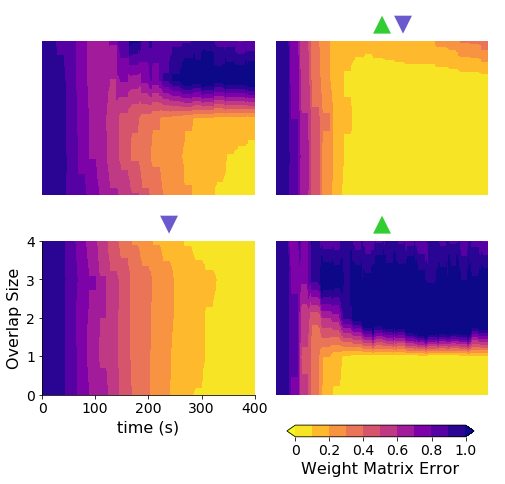

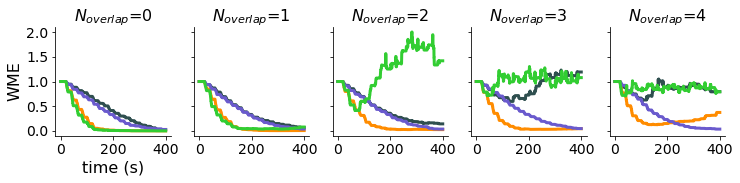

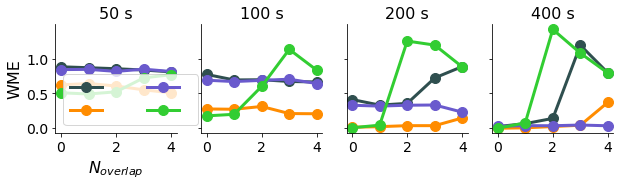

In [50]:
# Colormap

fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(8,6.5))

plt.sca(axs[0,0])
plt.contourf(T,L,ME0,N=12,aspect=500,cmap='plasma_r',levels=numpy.linspace(0,1,11),
             interpolation='nearest',extend='both')
axs[0,0].axis('off')
plt.title('',fontsize=18)

plt.sca(axs[0,1])
C1 = plt.contourf(T,L,ME1,N=12,aspect=500,cmap='plasma_r',levels=numpy.linspace(0,1,11),
                  interpolation='nearest',extend='both')
axs[0,1].axis('off')
plt.text(x=0.45,y=1.05,s=r'$\blacktriangle$',color='limegreen',fontsize=36,transform=axs[0,1].transAxes)
plt.text(x=0.55,y=1.05,s=r'$\blacktriangledown$',color='slateblue',fontsize=36,transform=axs[0,1].transAxes)

plt.sca(axs[1,0])
plt.contourf(T,L,MEex,N=12,aspect=500,cmap='plasma_r',levels=numpy.linspace(0,1,11),
             interpolation='nearest',extend='both')
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('Overlap Size',fontsize=16)
plt.xticks([0,100,200,300,400],fontsize=14)
plt.yticks([0,1,2,3,4],fontsize=14)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
plt.text(x=0.55,y=1.05,s=r'$\blacktriangledown$',color='slateblue',fontsize=36,transform=axs[1,0].transAxes)

plt.sca(axs[1,1])
plt.contourf(T,L,MEsy,N=12,aspect=500,cmap='plasma_r',levels=numpy.linspace(0,1,11),
             interpolation='nearest',extend='both')
axs[1,1].axis('off')
plt.text(x=0.45,y=1.05,s=r'$\blacktriangle$',color='limegreen',fontsize=36,transform=axs[1,1].transAxes)
fig.subplots_adjust(wspace=0.1,hspace=0.3)

cax = fig.add_axes([0.55, 0.035, 0.325, 0.025])
fig.colorbar(C1,cax=cax,label='Weight Matrix Error',orientation='horizontal')
cax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1.0'],fontsize=14)
cax.set_xlabel(cax.get_xlabel(),fontsize=16)

fig.savefig('./reworked_figs/ensemble_formation_overlap_ach_fullmap.svg')

#----------------------------------------------------------------------------------------------------------

fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(12,2),sharex=True,sharey=True)

colors = ['darkslategrey','darkorange','slateblue','limegreen']

for i in range(5):
    plt.sca(axs[i])
    for color,M in zip(colors,[ME0,ME1,MEex,MEsy]):
        plt.plot(time,M[i,:],color,lw=3)
        
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.title('$N_{overlap}$=%d'%(i),fontsize=16)
    
plt.sca(axs[0])
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('WME',fontsize=16)
plt.yticks(fontsize=14)

fig.savefig('./reworked_figs/ensemble_formation_overlap_ach_olslice.svg')

#----------------------------------------------------------------------------------------------------------

fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,2),sharex=True,sharey=True)

colors = ['darkslategrey','darkorange','slateblue','limegreen']

N = range(5)

for i in range(4):
    plt.sca(axs[i])
    for color,M in zip(colors,[ME0,ME1,MEex,MEsy]):
        plt.plot(N,M[:,int(250*2**(i-1)-1)],'-o',color=color,lw=3,ms=10)
        
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.title('%d'%(100*2**(i-1)) + ' s',fontsize=16)

plt.sca(axs[0])
plt.xlabel('$N_{overlap}$',fontsize=16)
plt.ylabel('WME',fontsize=16)
plt.yticks(fontsize=14)

plt.legend(['']*4,ncol=2,fontsize=16)

fig.savefig('./reworked_figs/ensemble_formation_overlap_ach_timeslice.svg')

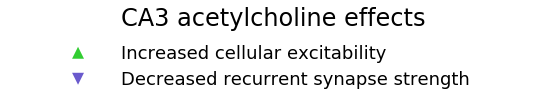

In [36]:
fig = plt.figure(figsize=(9,0.6))

plt.text(x=0.1,y=0.1,s=r'$\blacktriangledown$',color='slateblue',fontsize=24)
plt.text(x=0.2,y=0.1,s='Decreased recurrent synapse strength',fontsize=18)

plt.text(x=0.1,y=0.9,s=r'$\blacktriangle$',color='limegreen',fontsize=24)
plt.text(x=0.2,y=0.9,s='Increased cellular excitability',fontsize=18)

plt.text(x = 0.2,y=1.9,s='CA3 acetylcholine effects',fontsize=24)


fig.axes[0].axis('off')

fig.savefig('./reworked_figs/ach_legend.svg')